<a href="https://colab.research.google.com/github/sturu1/THU-PM/blob/master/Copy_of_5_2_2_using_convnets_with_small_datasets_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # 5.2 - 소규모 데이터셋에서 컨브넷 사용하기. 

**이번에는 컴퓨터 비전에서 과대적합을 줄이기 위한 강력한 방법인 (2)데이터 증식**을 소개하겠습니다. 데이터 증식을 통해 네트워크의 성능을 82% 정확도로 향상시킬 것입니다.


데이터를 내려받고 폴더별로 정리하기 위해서 앞에서 사용한 코드를 그대로 사용하겠습니다. 
특히 colab에서는 앞에서 내려받은 데이터는 colab을 종료하거나 일정 시간이 지난후에는 모두 사라지게 됩니다.

In [57]:
!git clone https://github.com/gilbutITbook/006975.git

fatal: destination path '006975' already exists and is not an empty directory.


In [58]:
import os, shutil
# 원본 데이터셋을 압축 해제한 디렉터리 경로
original_dataset_dir = '/content/006975/datasets/cats_and_dogs/train'
# 소규모 데이터셋을 저장할 디렉터리
base_dir = './cats_and_dogs_small'
if os.path.exists(base_dir):  # 반복적인 실행을 위해 디렉토리를 삭제합니다.
    shutil.rmtree(base_dir)   # 이 코드는 책에 포함되어 있지 않습니다.
os.mkdir(base_dir)
# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)
# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)
# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)
# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)
# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
# 다음 500개 고양이 이미지를 validation_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
# 다음 500개 고양이 이미지를 test_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
# 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 validation_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 test_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

## 데이터 증식 사용하기

**과대적합은 학습할 샘플이 너무 적어 새로운 데이터에 일반화할 수 있는 모델을 훈련시킬 수 없기 때문에 발생**합니다. 무한히 많은 데이터가 주어지면 데이터 분포의 모든 가능한 측면을 모델이 학습할 수 있을 것입니다. **데이터 증식은 기존의 훈련 샘플로부터 더 많은 훈련 데이터를 생성하는 방법**입니다. 이 방법은 그럴듯한 이미지를 생성하도록 여러 가지 **랜덤한 변환을 적용**하여 샘플을 늘립니다. 훈련 시에 모델이 정확히 같은 데이터를 두 번 만나지 않도록 하는 것이 목표입니다. 모델이 데이터의 여러 측면을 학습하면 일반화에 도움이 될 것입니다.

케라스에서는 `ImageDataGenerator`가 읽은 이미지에 여러 종류의 랜덤 변환을 적용하도록 설정할 수 있습니다. 예제를 먼저 만들어 보죠:

In [59]:
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

In [60]:
datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

In [61]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

In [62]:
fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])

In [63]:
img_path = fnames[3]

In [64]:
img = image.load_img(img_path, target_size = (150, 150))

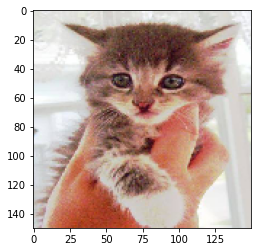

In [65]:
plt.imshow(img)

In [66]:
#tensor의 형태로 바꿔줘야함
x = image.img_to_array(img)

In [67]:
x.shape

(150, 150, 3)

In [68]:
x = x.reshape(1, 150, 150, 3)

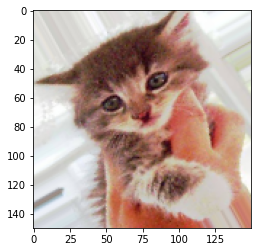

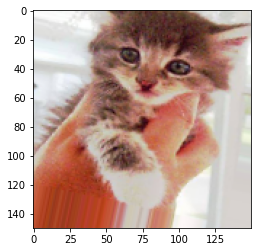

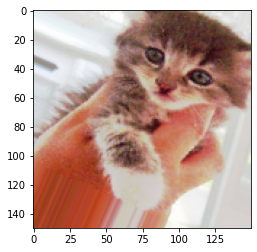

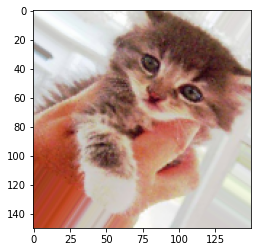

In [69]:
i = 0
for batch in datagen.flow(x, batch_size = 1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 4 == 0:
    break

추가적인 매개변수가 몇 개 더 있습니다(케라스 문서를 참고하세요). 이 코드를 간단히 살펴보죠.

* `rotation_range`는 랜덤하게 사진을 회전시킬 각도 범위입니다(0-180 사이).
* `width_shift_range`와 `height_shift_range`는 사진을 수평과 수직으로 랜덤하게 평행 이동시킬 범위입니다(전체 넓이와 높이에 대한 비율).
* `shear_range`는 랜덤하게 전단 변환을 적용할 각도 범위입니다.
* `zoom_range`는 랜덤하게 사진을 확대할 범위입니다.
* `horizontal_flip`은 랜덤하게 이미지를 수평으로 뒤집습니다. 수평 대칭을 가정할 수 있을 때 사용합니다(예를 들어, 풍경/인물 사진).
* `fill_mode`는 회전이나 가로/세로 이동으로 인해 새롭게 생성해야 할 픽셀을 채울 전략입니다.

증식된 이미지 샘플을 살펴보죠:

데이터 증식을 사용하여 새로운 네트워크를 훈련시킬 때 네트워크에 같은 입력 데이터가 두 번 주입되지 않습니다. 하지만 적은 수의 원본 이미지에서 만들어졌기 때문에 여전히 입력 데이터들 사이에 상호 연관성이 큽니다. 즉, 새로운 정보를 만들어낼 수 없고 단지 기존 정보의 재조합만 가능합니다. 그렇기 때문에 완전히 과대적합을 제거하기에 충분하지 않을 수 있습니다. 과대적합을 더 억제하기 위해 **완전 연결 분류기 직전에 `Dropout` 층을 추가**하겠습니다:

In [70]:
model = models.Sequential()

In [71]:
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape=(150, 150, 3)))

In [72]:
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [73]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

In [74]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [75]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'binary')

Found 2000 images belonging to 2 classes.


In [76]:
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'binary')

Found 1000 images belonging to 2 classes.


In [77]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'binary')

Found 1000 images belonging to 2 classes.


In [80]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 15,
    validation_data = validation_generator,
    validation_steps = 50)

Epoch 1/15
100/100 [==============================] - 28s 277ms/step - loss: 0.6096 - acc: 0.6599 - val_loss: 0.6224 - val_acc: 0.6675
Epoch 2/15
100/100 [==============================] - 25s 254ms/step - loss: 0.6009 - acc: 0.6666 - val_loss: 0.4727 - val_acc: 0.6546
Epoch 3/15
100/100 [==============================] - 25s 254ms/step - loss: 0.5965 - acc: 0.6806 - val_loss: 0.7711 - val_acc: 0.6681
Epoch 4/15
100/100 [==============================] - 25s 254ms/step - loss: 0.5816 - acc: 0.6935 - val_loss: 0.6309 - val_acc: 0.6456
Epoch 5/15
100/100 [==============================] - 25s 245ms/step - loss: 0.5785 - acc: 0.6907 - val_loss: 0.5593 - val_acc: 0.7278
Epoch 6/15
100/100 [==============================] - 27s 267ms/step - loss: 0.5726 - acc: 0.6967 - val_loss: 0.4441 - val_acc: 0.7262
Epoch 7/15
100/100 [==============================] - 25s 254ms/step - loss: 0.5680 - acc: 0.6941 - val_loss: 0.4998 - val_acc: 0.7176
Epoch 8/15
100/100 [==============================] - 2

   데이터 증식과 드롭아웃을 사용하여 이 네트워크를 훈련시켜 봅시다:
아래 코드는 코랩(GPU Type)에서 epoch 당 30여초 걸립니다. 따라서 교재와 같이 100epoch 훈련시키면 3000초 (약 50분) 정도의 시간이 소요됩니다. 
공부를 위해서 약 20회만 돌려보도록 하겠습니다. 

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [82]:
model.save('/content/drive/My Drive/Colab Notebooks/cats_and_dogs_small_2.h5')

데이터 증식을 사용하지 않을때 보다 runtime이 조금더 길어지는 것을 알 수 있습니다. 데이터를 준비(증식)하는 시간이 포함되기 때문입니다. 

다음 절에서 이 모델을 사용하기 위해 모델을 저장합니다.

결과 그래프를 다시 그려 보죠:

그림 5-12와 5-13을 참고하세요. 데이터 증식과 드롭아웃 덕택에 더이상 과대적합되지 않습니다. 훈련 곡선이 검증 곡선에 가깝게 따라가고 있습니다. 검증 데이터에서 82% 정확도를 달성하였습니다. 규제하지 않은 모델과 비교했을 때 15% 정도 향상되었습니다.

다른 규제 기법을 더 사용하고 네트워크의 파라미터를 튜닝하면(합성곱 층의 필터 수나 네트워크의 층의 수 등) 86%나 87% 정도까지 더 높은 정확도를 얻을 수도 있습니다. 하지만 데이터가 적기 때문에 컨브넷을 처음부터 훈련해서 더 높은 정확도를 달성하기는 어렵습니다. 이런 상황에서 정확도를 높이기 위한 다음 단계는 사전 훈련된 모델을 사용하는 것입니다. 다음 두 절에서 이에 대해 집중적으로 살펴보겠습니다.